In [1]:
import geopandas
import font_management
import json
import party_information
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

#Prepare the raw data
ELECTION_RESULTS_FILE = 'election_data/dataset_elections_bfs.json'
with open(ELECTION_RESULTS_FILE) as f:
    election_results = json.load(f)

cantonal_results = dict()
for result in election_results['level_kantone']:
    if result['kanton_nummer'] not in cantonal_results.keys():
        cantonal_results[result['kanton_nummer']] = {
            'name': result['kanton_bezeichnung'],
            'parties': {}
        }
    cantonal_results[result['kanton_nummer']]['parties'][result['partei_id']] = \
        {
            'name': party_information.party_metadata[result['partei_id']]['name'],
            'group': party_information.party_metadata[result['partei_id']]['group'],
            'vote_share': result['partei_staerke'],
            'vote_share_delta': result['differenz_partei_staerke'],
            'strongest_party': True if result['flag_staerkste_partei'] else False
        }
municipal_results = dict()
for result in election_results['level_gemeinden']:
    if result['gemeinde_nummer'] not in municipal_results.keys():
        municipal_results[result['gemeinde_nummer']] = {
            'name': result['gemeinde_bezeichnung'],
            'parties': {}
        }
    municipal_results[result['gemeinde_nummer']]['parties'][result['partei_id']] = \
        {
            'name': party_information.party_metadata[result['partei_id']]['name'],
            'group': party_information.party_metadata[result['partei_id']]['group'],
            'vote_share': result['partei_staerke'],
            'vote_share_delta': result['differenz_partei_staerke'],
            'strongest_party': True if result['flag_staerkste_partei'] else False
        }

def calc_winning_group(party_dict: dict, attribute_to_sum: str) -> str:
    """Takes the parties dictionary iterates through it and sums the attribute together which are defined in the attribute to sum. It's a necessity that the attribute_to_sum is existing in the dictionary, otherwise it will fail. Returns the winning group."""
    conservative_sum = 0
    middle_sum = 0
    left_sum = 0
    for key, value in party_dict.items():
        if value[attribute_to_sum] is None:
            pass
        else:
            if key in party_information.conservative_id:
                conservative_sum += value[attribute_to_sum]
            elif key in party_information.middle_id:
                middle_sum += value[attribute_to_sum]
            elif key in party_information.left_id:
                left_sum += value[attribute_to_sum]
    if conservative_sum > middle_sum and conservative_sum > left_sum:
        return 'conservative'
    elif middle_sum > conservative_sum and middle_sum > left_sum:
        return 'middle'
    elif left_sum > middle_sum and left_sum > conservative_sum:
        return 'left'

#Bundle winner/grower munciaplities together
winner_aggregation = {'conservative': [], 'middle': [], 'left': []}
grower_aggregation = {'conservative': [], 'middle': [], 'left': []}
for _id, municipal_data in municipal_results.items():
    municipal_data['vote_winner'] = calc_winning_group(municipal_data['parties'], 'vote_share')
    municipal_data['growth_winner'] = calc_winning_group(municipal_data['parties'], 'vote_share_delta')
    if municipal_data['vote_winner'] == 'conservative':
        winner_aggregation['conservative'].append(_id)
    elif municipal_data['vote_winner'] == 'middle':
        winner_aggregation['middle'].append(_id)
    elif municipal_data['vote_winner'] == 'left':
        winner_aggregation['left'].append(_id)

    if municipal_data['growth_winner'] == 'conservative':
        grower_aggregation['conservative'].append(_id)
    elif municipal_data['growth_winner'] == 'middle':
        grower_aggregation['middle'].append(_id)
    elif municipal_data['growth_winner'] == 'left':
        grower_aggregation['left'].append(_id)

#Prepare Geodataframe (remove , engine="pyogrio" in case data is loaded on mac)
swiss_map = geopandas.read_file('swisstopo/Hoheitsgebiete.shp', engine="pyogrio")
#Drop the Lichtenstein areas with ICC = LI
swiss_map = swiss_map[swiss_map['ICC'] != 'LI']
swiss_map['winning_group'] = ''
swiss_map['growing_group'] = ''
for index, row in swiss_map.iterrows():
    if row['BFS_NUMMER'] in grower_aggregation['conservative']:
        swiss_map.at[index, 'growing_group'] = 'conservative'
    elif row['BFS_NUMMER'] in grower_aggregation['middle']:
        swiss_map.at[index, 'growing_group'] = 'middle'
    elif row['BFS_NUMMER'] in grower_aggregation['left']:
        swiss_map.at[index, 'growing_group'] = 'left'
    else:
        swiss_map.at[index, 'growing_group'] = 'no_data'

    if row['BFS_NUMMER'] in winner_aggregation['conservative']:
        swiss_map.at[index, 'winning_group'] = 'conservative'
    elif row['BFS_NUMMER'] in winner_aggregation['middle']:
        swiss_map.at[index, 'winning_group'] = 'middle'
    elif row['BFS_NUMMER'] in winner_aggregation['left']:
        swiss_map.at[index, 'winning_group'] = 'left'
    else:
        swiss_map.at[index, 'winning_group'] = 'no_data'

#Prepare canton map (remove , engine="pyogrio" in case data is loaded on mac)
map_canton = geopandas.read_file('swisstopo/Kantonsgebiet.shp', engine="pyogrio")
#Prepare color codding for the map
swiss_map['winning_group_color'] = swiss_map['winning_group'].map(party_information.COLOR_DICT)
swiss_map['growing_group_color'] = swiss_map['growing_group'].map(party_information.COLOR_DICT)
#Fix nan values with a grey color
swiss_map['winning_group_color'] = swiss_map['winning_group_color'].fillna(party_information.GREY_COLOR)
swiss_map['growing_group_color'] = swiss_map['growing_group_color'].fillna(party_information.GREY_COLOR)


## Swiss elections 2023 - who’s the real winner?

In the autumn of 2023, the Swiss parliament was newly elected. At an initial glance, the results appear unequivocal, with the conservative groups dominating. However, the Swiss political system is based on concordance rather than strength alone, emphasizing a nuanced evaluation of power dynamics. So the pivotal question arises who really has won in terms of power shifts. 

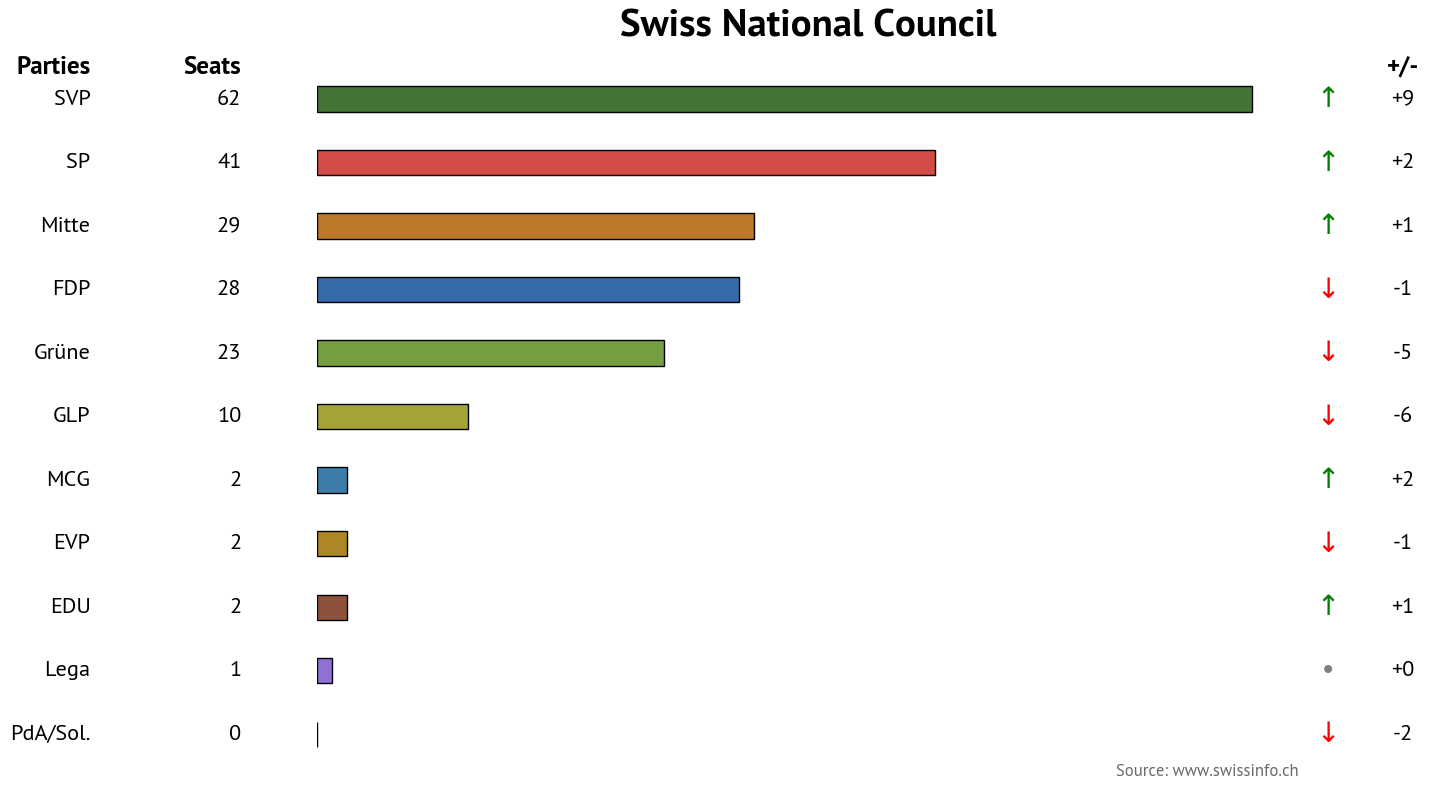

In [3]:
#| label: winners_chart
#| fig-align: center
#| layout-align: center

import matplotlib.pyplot as plt
import numpy as np
from font_management import TITLE_FONT, SUBTITLE_FONT, DESCRIPTION_FONT, ANNOTATION_FONT

parties = ['SVP', 'SP', 'Mitte', 'FDP', 'Grüne', 'GLP', 'MCG', 'EVP', 'EDU', 'Lega', 'PdA/Sol.']
seats = [62, 41, 29, 28, 23, 10, 2, 2, 2, 1, 0]
colors = ['#437537', '#d24d46', '#bc7729', '#366ba9', '#769f41', '#a3a336', '#3d7daa', '#ae8725', '#8b513a', '#9070d4', '#FF3399']
changes = [9, 2, 1, -1, -5, -6, 2, -1, 1, 0, -2]
manuel_sequence = ['SVP', 'SP', 'Mitte', 'FDP', 'Grüne', 'GLP', 'MCG', 'EVP', 'EDU', 'Lega', 'PdA/Sol.']
sorted_data = sorted(zip(parties, seats, colors, changes), key=lambda x: manuel_sequence.index(x[0]))
sorted_parties, sorted_seats, sorted_colors, sorted_changes = zip(*sorted_data)
reversed_seats = list(reversed(sorted_seats))
reversed_colors = list(reversed(sorted_colors))
reversed_changes = list(reversed(sorted_changes))
reversed_parties = list(reversed(sorted_parties))

fig, ax = plt.subplots(figsize=(15, 8))
bar_positions = np.arange(len(reversed_parties))
bars = ax.barh(bar_positions, reversed_seats, color=reversed_colors, edgecolor='black', height=0.4)

ax.text(-15, len(reversed_parties) - 0.5, 'Parties', ha='right', va='center', **SUBTITLE_FONT)
ax.text(-5, len(reversed_parties) - 0.5, 'Seats', ha='right', va='center', **SUBTITLE_FONT)
ax.text(seats[0] + 10, len(reversed_parties) - 0.5, '+/-', ha='center', va='center', **SUBTITLE_FONT)

for y, party in zip(bar_positions, reversed_parties):
    ax.text(-15, y, party, ha='right', va='center', **DESCRIPTION_FONT) 
for y, seat in zip(bar_positions, reversed_seats):
    ax.text(-5, y, seat, ha='right', va='center', **DESCRIPTION_FONT) 
for y, change in zip(bar_positions, reversed_changes):
    if change > 0:
        ax.text(seat + 5, y, '↑', ha='center', va='center', fontsize=20, color='green')  
    elif change < 0:
        ax.text(seat + 5, y, '↓', ha='center', va='center', fontsize=20, color='red')  
    else:
        ax.text(seat + 5, y, '•', ha='center', va='center', fontsize=20, color='grey')  
for y, change in zip(bar_positions, reversed_changes):
    ax.text(seat + 10, y, f'{change:+}', ha='center', va='center', **DESCRIPTION_FONT) 


fig.text(x=1, y=0, s='Source: www.swissinfo.ch', ha='right', va='bottom', transform=ax.transAxes, **ANNOTATION_FONT)
    
ax.axis('off')
ax.set_title('Swiss National Council', **TITLE_FONT)
plt.tight_layout()
plt.show()


The national council's final results are displayed in the chart above along with the corresponding seats. This reflects the effective power in this chamber of parliament and highlights the wins of the conservative party ‘SVP’ - which is also accurate and crucial to note. Nevertheless, the process for allocating seats is intricate and involves so-called ‘list combinations’ making it difficult to see through (e.g. the liberal greens have lost 0.5% of the electorate and lost 6 seats). Regardless of the final seat totals, our analysis will concentrate on the percentages that the parties actually received from the electorate to examine the trend of the electorate.

## Grouping parties into political sections
Our analysis can be further simplified by classifying the numerous political parties into three main categories: left, middle, and conservative forces. Facilitating a broader understanding, the simplification directs attention towards general trends rather than fixating on individual party intricacies. 

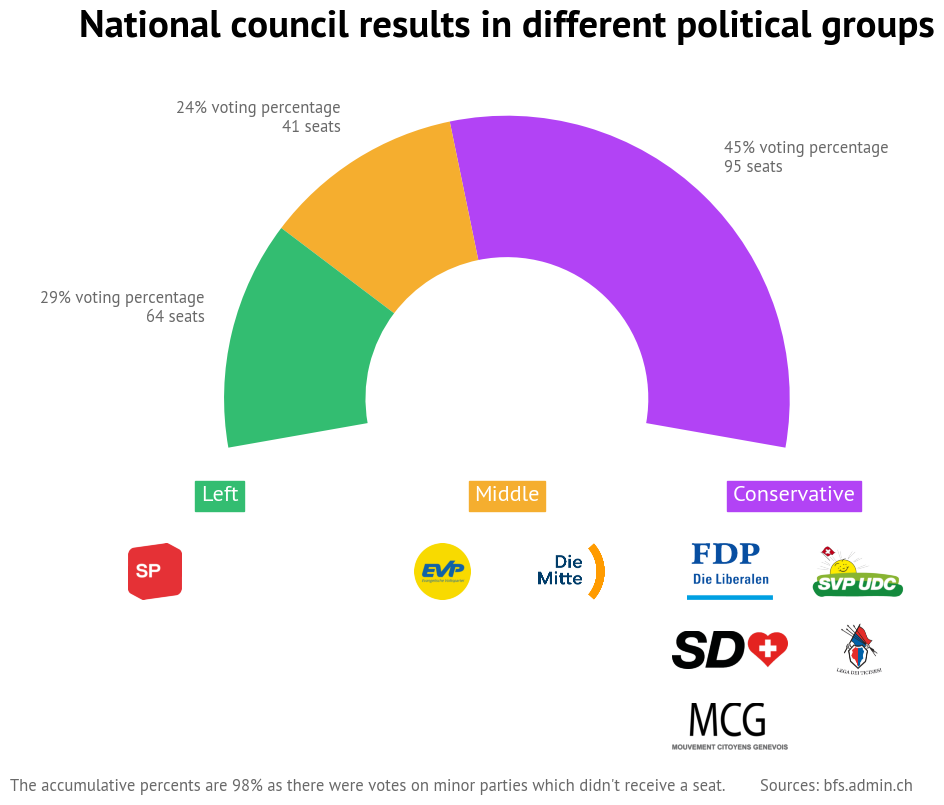

In [1]:
#| label: party_grouping_chart
#| echo: false

import party_information
import font_management
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(party_information.party_results_nc).T
df = df[df['group'] != 'unrelevant']
df = df[df['name'] != 'Christlichsoziale Partei']
df = df[df['name'] != 'Grün-Alternative (inkl. POCH)']

grouped_data = df.groupby('group')['vote_result'].sum()

total_votes = grouped_data.sum()
grouped_data[''] = total_votes / 1.25  # Make the empty half equal to the sum of the other half
grouped_data = grouped_data.reindex(["conservative", "middle", "left", ''])
labels = ['45% voting percentage\n95 seats', '24% voting percentage\n41 seats', '29% voting percentage\n64 seats', '']

# Creating the half-donut chart
fig, axes = plt.subplot_mosaic("DDD;ABC", height_ratios=[1,1], figsize=(10, 10))
pie_ax = axes['D']
pie_ax.set_title('National council results in different political groups', fontdict=font_management.TITLE_FONT, transform=pie_ax.transAxes)
wedges, texts = pie_ax.pie(grouped_data, labels=labels, textprops=font_management.ANNOTATION_FONT, colors=[party_information.COLOR_DICT[key] for key in grouped_data.index],
                       wedgeprops=dict(width=0.5), startangle=-10)
pie_ax.set_ylim(0.5, 1.25)
# Adjusting the start angle so 'left' starts on the left
logos = {
    'FDP.Die Liberalen': 'party_logos/fdp.png',
    'Sozialdemokratische Partei der Schweiz': 'party_logos/sp.gif',
    'Schweizerische Volkspartei': 'party_logos/svp.gif',
    'GRÜNE Schweiz': 'party_logos/gruene.png',
    'Grünliberale Partei': 'party_logos/glp.png',
    'Evangelische Volkspartei der Schweiz': 'party_logos/evp.png',
    'Die Mitte': 'party_logos/Mitte.png',
    'Mouvement Citoyens Romands': 'party_logos/mcg.png',
    'Lega dei Ticinesi': 'party_logos/lega.jpeg',
    'Partei der Arbeit / Solidarität': 'party_logos/pda.png',
    'Schweizer Demokraten': 'party_logos/sd.png',
    'Eidgenössisch-Demokratische Union': 'party_logos/edu.png',
}
party_to_group = df.set_index('name')['group'].to_dict()
party_axes = [axes['A'], axes['B'], axes['C']]
# Define fixed size for all logos based on a 2x3 grid (the most dense grid we have)
# We assume the most logos we can have in a row or column is 3
max_logos_per_row = 2
max_logos_per_col = 3
image_padding = 0.05  # Padding around the image
subplot_padding = 0.3  # Padding between subplots

# Calculate the size for each logo
logo_width = (1 - image_padding * (max_logos_per_row + 1)) / max_logos_per_row
logo_height = (1 - image_padding * (max_logos_per_col + 1)) / max_logos_per_col

# Function to calculate the grid layout based on the number of logos
def calculate_grid(n_l):
    if n_l <= 4:
        return 2, 2  # 2x2 grid for up to 4 logos
    else:
        return 3, 2  # 2x3 grid for more than 4 logos

# Iterate through each group and subplot
for ax, (group, color) in zip(party_axes, party_information.COLOR_DICT.items()):
    ax.set_title(group.capitalize(), fontdict=font_management.DESCRIPTION_FONT,color='white', backgroundcolor=color, pad=20)
    ax.axis('off')  # Turn off the axis

    # Get logos for the current group
    group_logos = [(party, logos[party]) for party, party_group in party_to_group.items() if party_group == group]

    # Calculate the grid layout
    n_logos = len(group_logos)
    n_rows, n_cols = calculate_grid(n_logos)

    # Place logos in the subplot
    for i, (party, logo_path) in enumerate(group_logos):
        # Calculate the row and column position
        row = i // n_cols
        col = i % n_cols

        # Calculate position for this logo
        left = image_padding + col * (logo_width + image_padding)
        bottom = 1 - (row + 1) * (logo_height + image_padding) - row * image_padding

        # Create an inset axis for the logo with fixed size
        logo_ax = ax.inset_axes([left, bottom, logo_width, logo_height])
        img = plt.imread(logo_path)
        logo_ax.imshow(img)
        logo_ax.axis('off')  # Turn off the axis for the logo
plt.tight_layout()
fig.text(x=0.8, y=0, s="Source: bfs.admin.ch", fontdict=font_management.ANNOTATION_FONT)
fig.text(x=0.05, y=0, s="The accumulative percents are 98% as there were votes on minor parties which didn't receive a seat.", fontdict=font_management.ANNOTATION_FONT)
plt.subplots_adjust(hspace=1.3, top=0.75, bottom=0.05)
plt.show()

This new perspective unveils the intricacies behind the political curtain, shedding light on the nuanced divisions within the parliament. Based on the numbers it becomes evident, that the direct translation of percentages into seat equivalents is not a straightforward correlation. Furthermore, it is apparent that certain percentages were overlooked due to their low marginal group status and lack of national significance (~2% of votes).

## How are the tendencies divided geographically?
In order to enhance the comprehension of the overall outcome, we will take a look at the municipalities where each political group secured the relative majority of votes. 

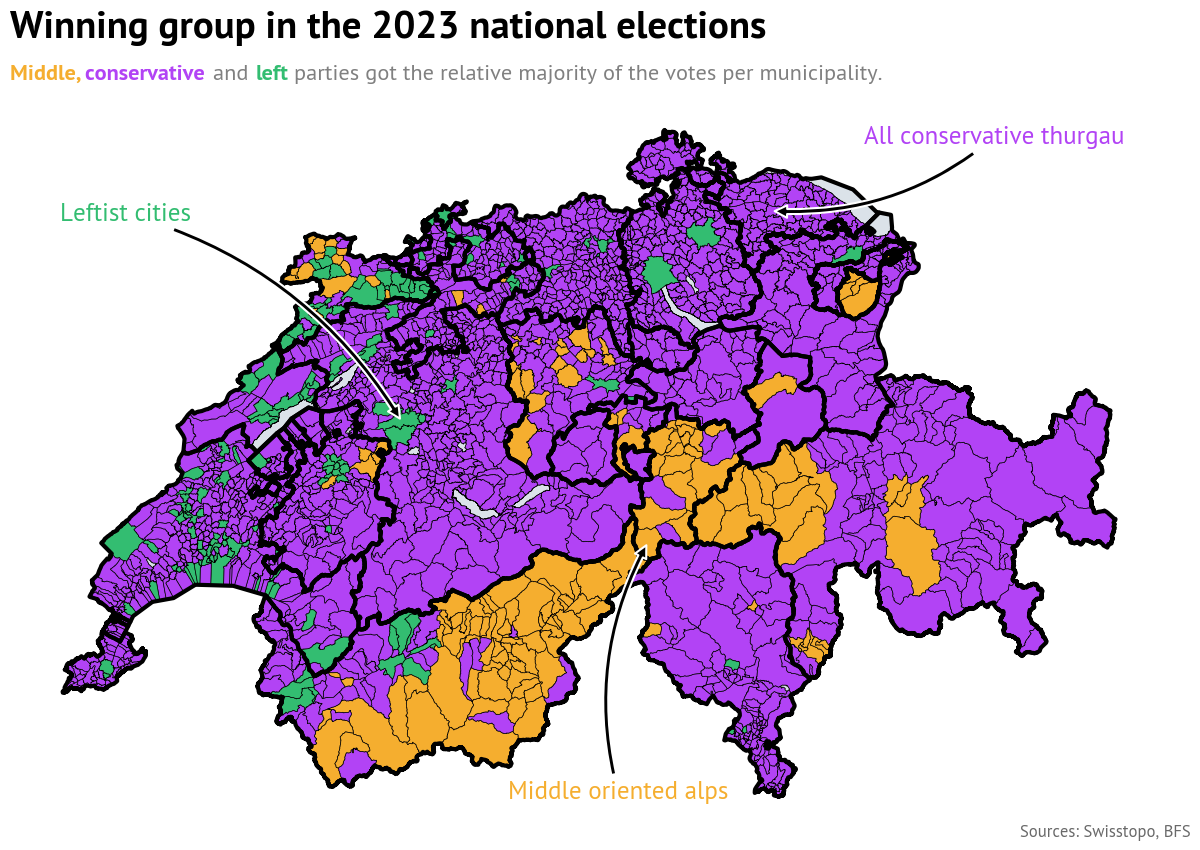

In [12]:
#| label: winning_group_map_chart
#| echo: false

#Prepare the annotations
arrowprops = {
    'arrowstyle': 'Simple',
    'edgecolor': 'white',
    'facecolor': 'black',
    'linewidth': 1.5,
}
def do_annotations(axis, items:dict):
    for key, item in items.items():
        axis.annotate(
            key,
            xy=(item[0]['geometry'].centroid.x, item[0]['geometry'].centroid.y), xycoords='data',
            xytext=item[1], textcoords='axes fraction',
            size=18, va="center", ha="center",
            arrowprops={'connectionstyle': "arc3,rad=-0.2", **arrowprops},
            fontproperties={'family': 'PT Sans', 'weight': 'regular'},
            color=item[2]
        )
#Select the areas for the annotations (manually chosen)
central_tg = swiss_map[swiss_map['BFS_NUMMER'] == 4881]
central_bern = swiss_map[swiss_map['BFS_NUMMER'] == 351]
municipality_alps = swiss_map[swiss_map['BFS_NUMMER'] == 1212]
annotation_items = {
    'All conservative thurgau': [central_tg, (0.85, 0.9), party_information.CONSERVATIVE_COLOR],
    'Middle oriented alps': [municipality_alps, (0.525, 0.05), party_information.MIDDLE_COLOR],
    'Leftist cities': [central_bern, (0.1, 0.8), party_information.LEFT_COLOR]
}
#Create the plot
f, ax = plt.subplots(figsize=(15,10))
ax.set_title('Winning group in the 2023 national elections', fontdict=font_management.TITLE_FONT, loc='left', transform=ax.transAxes)
ax.text(s='Middle, ', x=0.00, y=0.97, color=party_information.MIDDLE_COLOR,
        fontdict=font_management.DESCRIPTION_FONT, weight='bold', transform=ax.transAxes)
ax.text(s='conservative ', x=0.065, y=0.97, color=party_information.CONSERVATIVE_COLOR,
        fontdict=font_management.DESCRIPTION_FONT, weight='bold', transform=ax.transAxes)
ax.text(s='and ', x=0.175, y=0.97, color='grey',
        fontdict=font_management.DESCRIPTION_FONT, transform=ax.transAxes)
ax.text(s='left', x=0.212, y=0.97, color=party_information.LEFT_COLOR,
        fontdict=font_management.DESCRIPTION_FONT, weight='bold', transform=ax.transAxes)
ax.text(s='parties got the relative majority of the votes per municipality.', x=0.245, y=0.97, color='grey',
        fontdict=font_management.DESCRIPTION_FONT, transform=ax.transAxes)
results = swiss_map.plot(ax=ax, color=swiss_map['winning_group_color'], linewidth=0.5, edgecolor='black')
map_canton.plot(ax=ax, linewidth=3, edgecolor='black', color=(0, 0, 0, 0))
ylim = ax.get_ylim()
y_buffer = (ylim[1] - ylim[0]) * 0.05
ax.set_ylim(ylim[0], ylim[1] + y_buffer)
do_annotations(ax, annotation_items)
f.text(x=0.8, y=0.1, s="Sources: Swisstopo, BFS", fontdict=font_management.ANNOTATION_FONT)
ax.set_axis_off()

For Swiss politics, a discernible pattern can be recognized. The conservative forces hold control in the majority of the smaller land-like areas such as the canton of Thurgau, devoid of sizable urban centres and predominantly conservative. In contrast, larger areas like Berne, highlighted on the map, exhibit a left-leaning orientation. The middle parties emerge as clear winners across the high mountain alpine regions. This is due to the historical association of the largest middle party, rooted in Catholicism, which continues to wield considerable influence in these areas. So far, the election unfolds without anomalies.

However, the picture changes significantly when we examine the relative changes in the number of votes that each group received.

## Relative shifts in power
The following chart depicts which groups experienced the most percentage growth within each municipality.

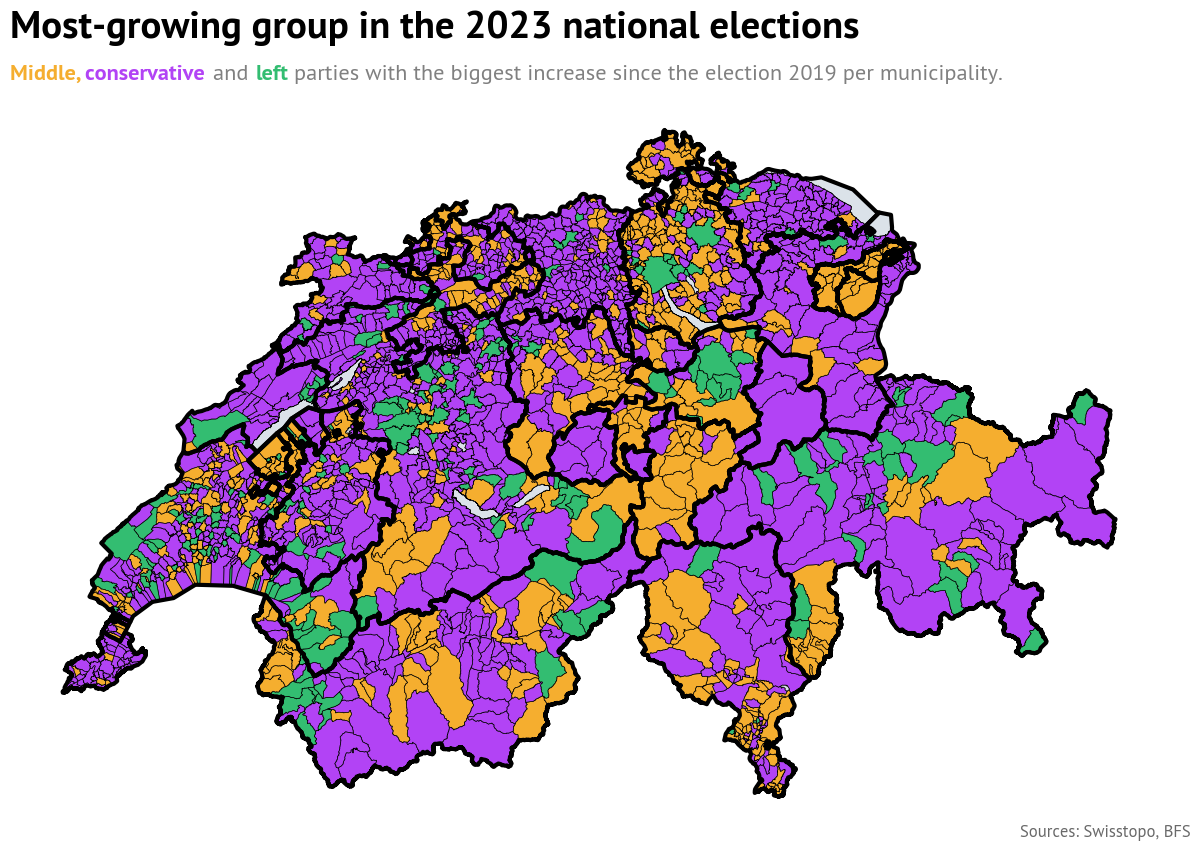

In [11]:
#| label: most_growing_map_chart
#| echo: false
f, ax = plt.subplots(figsize=(15,10))
ax.set_title('Most-growing group in the 2023 national elections', fontdict=font_management.TITLE_FONT, loc='left', transform=ax.transAxes)
ax.text(s='Middle, ', x=0.00, y=0.97, color=party_information.MIDDLE_COLOR,
        fontdict=font_management.DESCRIPTION_FONT, weight='bold', transform=ax.transAxes)
ax.text(s='conservative ', x=0.065, y=0.97, color=party_information.CONSERVATIVE_COLOR,
        fontdict=font_management.DESCRIPTION_FONT, weight='bold', transform=ax.transAxes)
ax.text(s='and ', x=0.175, y=0.97, color='grey',
        fontdict=font_management.DESCRIPTION_FONT, transform=ax.transAxes)
ax.text(s='left', x=0.212, y=0.97, color=party_information.LEFT_COLOR,
        fontdict=font_management.DESCRIPTION_FONT, weight='bold', transform=ax.transAxes)
ax.text(s='parties with the biggest increase since the election 2019 per municipality.', x=0.245, y=0.97, color='grey',
        fontdict=font_management.DESCRIPTION_FONT, transform=ax.transAxes)
results = swiss_map.plot(ax=ax, color=swiss_map['growing_group_color'], linewidth=0.5, edgecolor='black')
map_canton.plot(ax=ax, linewidth=3, edgecolor='black', color=(0, 0, 0, 0)) # Thicker canton borders
ax.set_axis_off()
ylim = ax.get_ylim()
y_buffer = (ylim[1] - ylim[0]) * 0.05
ax.set_ylim(ylim[0], ylim[1] + y_buffer)
f.text(x=0.8, y=0.1, s="Sources: Swisstopo, BFS", fontdict=font_management.ANNOTATION_FONT)
plt.show()

Compared to the overall winner, it is immediately apparent that a greater number of municipalities had the largest gain in middle parties. However, the conservatives also achieved some increase in percentage in the western region of Switzerland.

Let's go even further to analyze which municipality experienced the largest growth for a particular group in which they do not hold a relative majority. Thus, if the leading group is left or conservative, but the middle party has the largest growth, the municipality is marked as belonging to the middle party.

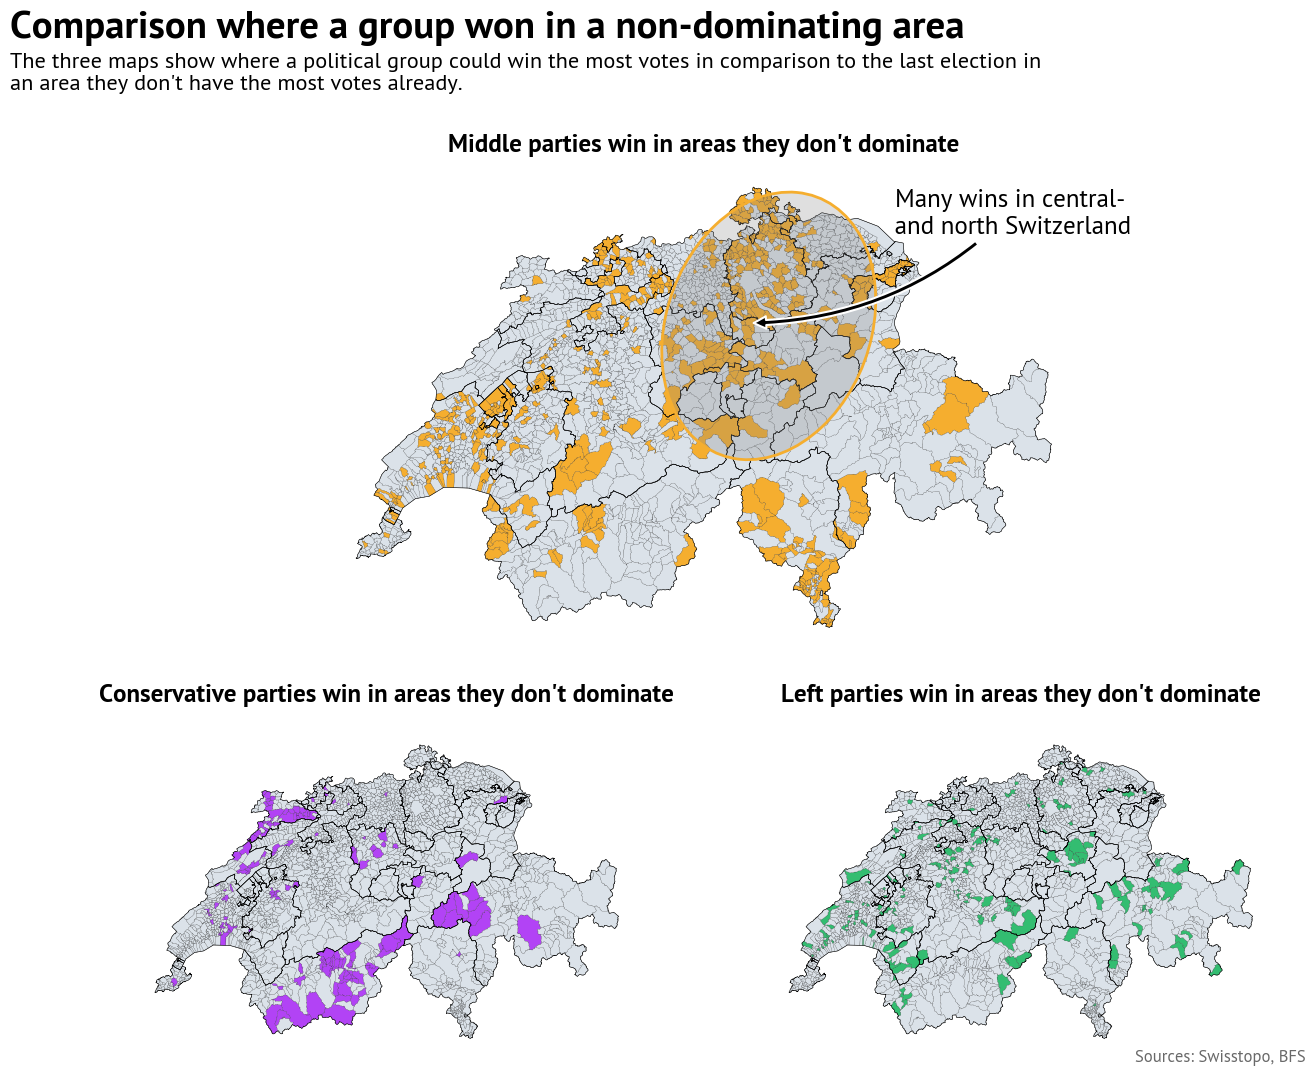

In [13]:
#| label: comparison_map_chart
#| echo: false

#Prepare color codding for the map
def color_for_scenario(data, winning_group_condition, growing_group, color):
    """
    Return color for each area based on the specified condition.
    """
    return [
        color if row['winning_group'] != winning_group_condition and row['growing_group'] == growing_group
        else party_information.GREY_COLOR
        for _, row in data.iterrows()
    ]
#Prepare annotations
central_circle = swiss_map[swiss_map['BFS_NUMMER'] == 1701]
annotation_items = {
    'Many wins in central-\n and north Switzerland': [central_circle, (0.9, 0.9), 'black'],
}
#Create the plot
fig, axes = plt.subplot_mosaic(
    "CC;AB",
    height_ratios=[1.5, 1],
    figsize=(15, 12),
    gridspec_kw={'hspace': 0.2, 'top': 0.85}
)
# Main title of the figure
fig.text(x=0.05, y=0.95,s='Comparison where a group won in a non-dominating area', fontdict=font_management.TITLE_FONT)
# Subtitle of the figure!
fig.text(x=0.05, y=0.91, s="The three maps show where a political group could win the most votes in comparison to the last election in \nan area they don't have the most votes already.", fontdict=font_management.DESCRIPTION_FONT)
# First Map
swiss_map['custom_color'] = color_for_scenario(swiss_map, 'conservative', 'conservative', party_information.CONSERVATIVE_COLOR)
swiss_map.plot(ax=axes['A'], color=swiss_map['custom_color'], linewidth=0.1, edgecolor='black')
axes['A'].set_title('Conservative parties win in areas they don\'t dominate', fontdict=font_management.SUBTITLE_FONT, loc='center')
map_canton.plot(ax=axes['A'], linewidth=0.4, edgecolor='black', color=(0, 0, 0, 0))
axes['A'].set_axis_off()

# Second Map
swiss_map['custom_color'] = color_for_scenario(swiss_map, 'middle', 'middle', party_information.MIDDLE_COLOR)
swiss_map.plot(ax=axes['C'], color=swiss_map['custom_color'], linewidth=0.1, edgecolor='black')
axes['C'].set_title('Middle parties win in areas they don\'t dominate', fontdict=font_management.SUBTITLE_FONT, loc='center')
map_canton.plot(ax=axes['C'], linewidth=0.4, edgecolor='black', color=(0, 0, 0, 0))
axes['C'].set_axis_off()
#Make the annotation
do_annotations(axes['C'], annotation_items)
ellipse_center = (0.5, 0.83)
ellipse_width = 0.18
ellipse_height = 0.35
ellipse = Ellipse(ellipse_center, width=ellipse_width, height=ellipse_height,
                  edgecolor=party_information.MIDDLE_COLOR, facecolor=(0.5, 0.5, 0.5, 0.25), lw=2, transform=ax.transAxes, angle=-8)

# Add the ellipse to the plot
axes['C'].add_patch(ellipse)

# Third Map
swiss_map['custom_color'] = color_for_scenario(swiss_map, 'left', 'left', party_information.LEFT_COLOR)
swiss_map.plot(ax=axes['B'], color=swiss_map['custom_color'], linewidth=0.1, edgecolor='black')
axes['B'].set_title('Left parties win in areas they don\'t dominate', fontdict=font_management.SUBTITLE_FONT, loc='center')
#Cantonal outlines
map_canton.plot(ax=axes['B'], linewidth=0.4, edgecolor='black', color=(0, 0, 0, 0))
axes['B'].set_axis_off()

fig.text(x=0.8, y=0.1, s="Sources: Swisstopo, BFS", fontdict=font_management.ANNOTATION_FONT)
plt.show()

There is an adequate explanation why the results analysis graphic is narrowly focused. In a great deal of areas that they do not control, no other party could secure the most percentage. It's remarkable that they prevailed in so many regions, including the northeast to central Switzerland, where the majority of people are conservative.

Upon examining the results from this perspective, one would have to conclude that the secret winner of the election is the middle parties. 

## Rural municipalities to cities – does population size matter for elections? 
Our political beliefs are strongly influenced by the way we live. Depending on where you live—in a 300-person village or Zurich, home to 430 000 people—society is different.

In following chart we have analysed the group strength based on the size of the municipality. For people familiar with Swiss politics, and considering the first charts showing the winners per municipality, the results are not astonishing. 

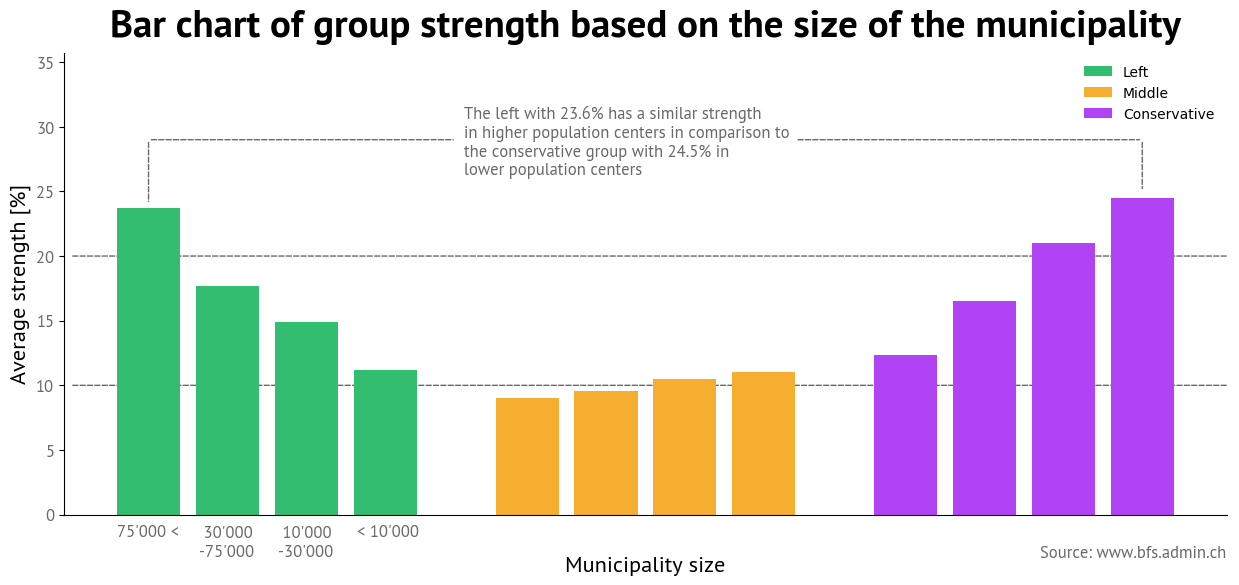

In [4]:
#| label: municipality_bar_chart
#| echo: false

import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from font_management import TITLE_FONT, SUBTITLE_FONT, DESCRIPTION_FONT, ANNOTATION_FONT

party_data = {
    '3': [[],[],[],[]],
    '13': [[],[],[],[]],
    '31': [[],[],[],[]],
    '1': [[],[],[],[]],
    '34': [[],[],[],[]],
    '4': [[],[],[],[]]
}

averaged_party_data_id = {
    '3': [],
    '13': [],
    '31': [],
    '1': [],
    '34': [],
    '4': []
}

averaged_party_data_names = {
    'SP': [],
    'GRÜNE': [],
    'GLP': [],
    'FDP': [],
    'Mitte': [],
    'SVP': []
}

    
    
def get_party_by_id(party_data, party_id):
    for party in party_data:
        if party.get('partei_id') == party_id:
            return party
    return None


def create_party_id_description_map(party_data):
    id_description_map = {}
    for party in party_data:
        short_description = next((desc['text'] for desc in party['partei_bezeichnung_kurz'] if desc['langKey'] == 'de'), 'Keine Beschreibung')
        id_description_map[party['partei_id']] = short_description

    return id_description_map


def extract_election_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    election_data_municipality_level = data.get('level_gemeinden', [])
    return election_data_municipality_level


def get_inhabitants_amount_voted(data_map, municipality_id, percentage):
    if municipality_id in data_map:
        inhabitants_in_municipality = data_map[municipality_id]
        percentage_voted = inhabitants_in_municipality * percentage
        return percentage_voted
    else:
        return None


def calculate_average_party_strength(election_data):
    party_strengths = defaultdict(list)

    for entry in election_data:
        party_id = entry.get('partei_id')
        party_strength = entry.get('partei_staerke')

        if party_id is not None and party_strength is not None:
            if isinstance(party_strength, str) and party_strength.endswith('%'):
                party_strength = float(party_strength.strip('%')) / 100
            elif isinstance(party_strength, str):
                party_strength = float(party_strength)

            party_strengths[party_id].append(party_strength)

    average_strengths = {party: sum(strengths) / len(strengths) for party, strengths in party_strengths.items()}
    return average_strengths


def fill_party_data():
    keys = party_data.keys()
    for entry in election_data_municipality_level:
        party_id = str(entry.get('partei_id'))
        party_strength = entry.get('partei_staerke')
        municipality_id = entry.get('gemeinde_nummer')
        inhabitants_in_municipality = inhabitants_map.get(str(municipality_id).zfill(4))
        if party_id in keys and inhabitants_in_municipality != None:
            if party_strength != None:
                if inhabitants_in_municipality > 75000:
                    party_data[party_id][0].append(party_strength)
                elif 30000 <= inhabitants_in_municipality <= 75000:
                    party_data[party_id][1].append(party_strength)
                elif 10000 <= inhabitants_in_municipality < 30000:
                    party_data[party_id][2].append(party_strength)
                else:
                    party_data[party_id][3].append(party_strength)

                    
def calculate_average(lst):
    if len(lst) > 0:
        return sum(lst) / len(lst)
    else:
        return None  

    
def average_out_party_data():
    for key in party_data:
        averaged_party_data_id[key].append(calculate_average(party_data[key][0]))
        averaged_party_data_id[key].append(calculate_average(party_data[key][1]))
        averaged_party_data_id[key].append(calculate_average(party_data[key][2]))
        averaged_party_data_id[key].append(calculate_average(party_data[key][3]))
    
    
def fill_averaged_party_data_names():
    for key in averaged_party_data_id:
        averaged_party_data_names[party_id_description_map.get(int(key))] = averaged_party_data_id[key]       
        
        
def average_party_pairs(data, pairs):
    averaged_pairs = {}
    for pair in pairs:
        
        averaged_list = []
        
        list1 = data[str(pair[0])]
        list2 = data[str(pair[1])]

        if len(list1) != len(list2):
            raise ValueError("Lists to be averaged must have the same length.")

        for i in range(len(list1)):
            averaged_list.append((list1[i] + list2[i]) / 2)

        averaged_pairs[f"{pair[0]}_{pair[1]}"] = averaged_list

    averaged_pairs["Left"] = averaged_pairs.pop("3_13")
    averaged_pairs["Middle"] = averaged_pairs.pop("31_34")
    averaged_pairs["Conservative"] = averaged_pairs.pop("1_4")
    
    return averaged_pairs
        
        
def create_bucket_bar_chart(party_data):
    # Create a bar chart with adjusted spacing
    fig, ax = plt.subplots(figsize=(15, 6))  
    keys = list(party_data.keys())

    # This will hold the positions of the bars on the x-axis, including the extra spaces
    adjusted_bar_positions = []

    # The width of each bar
    bar_width = 0.8
    # The space to leave empty after the 4th and 8th bars
    space_width = 0.8
    # Starting position for the first bar
    current_position = 0

    # Define colors for each political group
    colors = {'Left': '#33BD71', 'Middle': '#F5AE2F', 'Conservative': '#B243F5'}

    bar_counter = 0 
    bucket_categories = ["75'000 <", " 30'000\n-75'000", " 10'000\n-30'000", "< 10'000"]

    # Loop through each political group and their corresponding values
    for group_index, (key, values) in enumerate(party_data.items()):
        color = colors.get(key, 'gray')
        for value_index, value in enumerate(values):
            # Add a space before the 5th and 9th bars
            if value_index == 0 and group_index > 0:
                current_position += space_width
            # Record the position of this bar
            adjusted_bar_positions.append(current_position)
            # Plot the bar
            ax.bar(current_position, value, label=key if value_index == 0 else "", color=color, width=bar_width)
            # Annotate the first set of bars with the bucket categories
            if group_index == 0:
                if bar_counter == 0:
                    ax.annotate(bucket_categories[value_index],
                                xy=(0, 0),
                                xytext=(-0.4, -2),  # Offset
                                **ANNOTATION_FONT)
                if bar_counter == 1:
                    ax.annotate(bucket_categories[value_index],
                                xy=(0, 0),
                                xytext=(0.64, -3.5),  # Offset
                                **ANNOTATION_FONT)
                if bar_counter == 2:
                    ax.annotate(bucket_categories[value_index],
                                xy=(0, 0),
                                xytext=(1.64, -3.5),  # Offset
                                **ANNOTATION_FONT)
                if bar_counter == 3:
                    ax.annotate(bucket_categories[value_index],
                                xy=(0, 0),
                                xytext=(2.64, -2),  # Offset
                                **ANNOTATION_FONT)
                bar_counter += 1
            # Move to the next position for the following bar
            current_position += 1
            
    # Adjust the y-axis limit as per user request
    ax.set_ylim(0, ax.get_ylim()[1] + 10)

    # Adding custom legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.legend(frameon=False)

    for label in ax.get_yticklabels():
        label.set_fontname(ANNOTATION_FONT['fontname'])
        label.set_fontsize(ANNOTATION_FONT['size'])
        label.set_color(ANNOTATION_FONT['color'])
        label.set_weight(ANNOTATION_FONT['weight'])

    
    # Set the chart title and labels
    ax.set_title("Bar chart of group strength based on the size of the municipality", **TITLE_FONT)
    ax.set_xlabel("Municipality size", **DESCRIPTION_FONT, labelpad=40)
    ax.set_ylabel("Average strength [%]", **DESCRIPTION_FONT)

    # Text annotation
    ax.annotate("",xy=(0,24),xytext=(0,29),xycoords="data",
             arrowprops={"arrowstyle" : "-", "linestyle" : "--",
                         "linewidth" : 1, "color": "dimgray"})
    
    ax.annotate("",xy=(3.9,29),xytext=(0,29),xycoords="data",
             arrowprops={"arrowstyle" : "-", "linestyle" : "--",
                         "linewidth" : 1, "color": "dimgray"})
   
    ax.annotate("",xy=(12.6,29),xytext=(8.2,29),xycoords="data",
             arrowprops={"arrowstyle" : "-", "linestyle" : "--",
                         "linewidth" : 1, "color": "dimgray"})
    
    ax.annotate("",xy=(12.6,25),xytext=(12.6,29),xycoords="data",
             arrowprops={"arrowstyle" : "-", "linestyle" : "--",
                         "linewidth" : 1, "color": "dimgray"})
    
    ax.annotate("",xy=(-1,20),xytext=(13.7,20),xycoords="data",
             arrowprops={"arrowstyle" : "-", "linestyle" : "--",
                         "linewidth" : 1, "color": "dimgray"}, zorder=0.5)
    
    ax.annotate("",xy=(-1,10),xytext=(13.7,10),xycoords="data",
             arrowprops={"arrowstyle" : "-", "linestyle" : "--",
                         "linewidth" : 1, "color": "dimgray"}, zorder=0.5)
    
    ax.annotate("The left with 23.6% has a similar strength\nin higher population centers in comparison to\nthe conservative group with 24.5% in\nlower population centers", 
                xy=(0,0), xytext=(4, 26), 
                **ANNOTATION_FONT)

    
    fig.text(x=1, y=-0.1, s='Source: www.bfs.admin.ch', ha='right', va='bottom', transform=ax.transAxes, **ANNOTATION_FONT)
    
    plt.xticks([])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Show the chart with the new adjustments
    plt.show()




#------------
extracted_file_path = 'election_data/extracted_parties.json'
with open(extracted_file_path, 'r', encoding='utf-8') as file:
    extracted_parties_data = json.load(file)

party_id_description_map = create_party_id_description_map(extracted_parties_data)

file_path = 'election_data/dataset_elections_bfs_municipalities_only.json' 
election_data_municipality_level = extract_election_data(file_path)


file_path = 'election_data/inhabitants_2022_index_value.csv'

data_df = pd.read_csv(file_path, delimiter=':', header=None)

inhabitants_map = data_df.set_index(0)[1].to_dict()

average_strengths = calculate_average_party_strength(election_data_municipality_level)

parties = list(average_strengths.keys())
averages = list(average_strengths.values())
party_names = list()
for party in parties:
    party_names.append(party_id_description_map[party])
    
fill_party_data()

average_out_party_data()
fill_averaged_party_data_names()

pairs_to_average = [(3, 13), (31, 34), (1, 4)]

averaged_data_for_political_grouping = average_party_pairs(averaged_party_data_id, pairs_to_average)


create_bucket_bar_chart(averaged_data_for_political_grouping)

It is now possible to propose that the variation in municipality sizes could account for the relative victories of the centre parties. At least for the brief span of four years, the shift in this data is too small to be taken into consideration as a real factor. Given that more people are living in larger areas and fewer in smaller ones, the outcomes of this election may serve as a preliminary sign of the shifting demographics.

## Results of both chambers
The Swiss Parliament includes two equally-powered chambers instead of just one. Until now, we had only looked at the national council, where we are already very familiar with the outcomes. Since the States Council (the second chamber), operates on a majority rather than a proportional voting system, our method of analysis cannot be applied in the same manner.

To gain an understanding of the entire picture, we will examine how the power is distributed in parliament when the states and national council are each given 50% of the total force. A state council is then given 1/46 of the 50% power, with the national council's voting strength being used for the remaining portion.

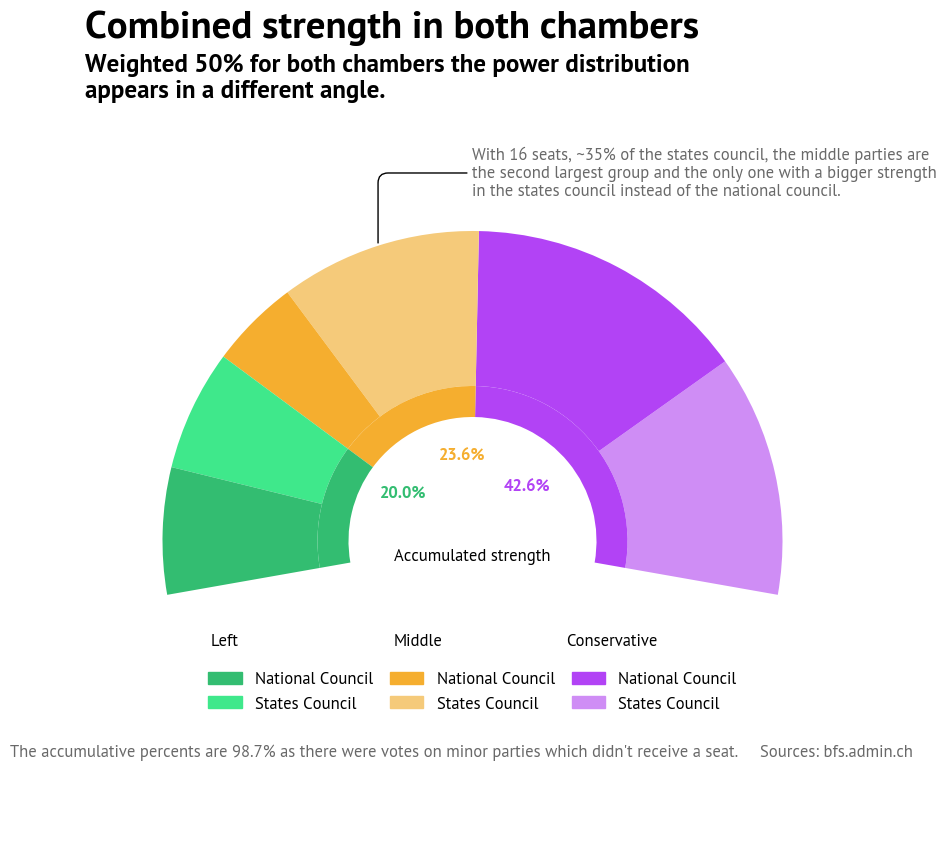

In [7]:
#| label: states_council_chart
#| echo: false

import party_information
import font_management
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

df = pd.DataFrame(party_information.party_results_sc).T

df_nc = pd.DataFrame(party_information.party_results_nc).T

grouped_results = df_nc[['name', 'normalised_parliamentary_power_nc', 'group']]
grouped_results = grouped_results.merge(df[['name', 'group', 'normalised_parliamentary_power_sc']], on='name')

chart_data = grouped_results.groupby('group_x').sum()[['normalised_parliamentary_power_nc', 'normalised_parliamentary_power_sc']]

color_map = {'conservative': party_information.CONSERVATIVE_COLOR, 'middle': party_information.MIDDLE_COLOR, 'left': party_information.LEFT_COLOR}
shade_map = {'conservative': party_information.CONSERVATIVE_SHADE, 'middle': party_information.MIDDLE_SHADE, 'left': party_information.LEFT_SHADE}
chart_data['color'] = chart_data.index.map(color_map)
chart_data['shade'] = chart_data.index.map(shade_map)
clean_df = chart_data.reset_index()

nc_values = clean_df.set_index('group_x')['normalised_parliamentary_power_nc']
nc_colors = clean_df.set_index('group_x')['color']
sc_values = clean_df.set_index('group_x')['normalised_parliamentary_power_sc']
sc_colors = clean_df.set_index('group_x')['shade']

# Concatenate the 'nc' and 'sc' values and colors into one series each, with appropriate multi-level indexing
combined_values = pd.concat([nc_values, sc_values], keys=['nc', 'sc'], names=['type', 'group']).sort_index(level='group')
combined_colors = pd.concat([nc_colors, sc_colors], keys=['nc', 'sc'], names=['type', 'group']).sort_index(level='group')

# Create a dataframe from the combined series
pivoted_df = pd.DataFrame({
       'value': combined_values.values,
       'color': combined_colors.values
}, index=combined_values.index).reset_index()

# Show the pivoted dataframe
#Reindex that the group order is conservative, middle, left
pivoted_df = pivoted_df.reindex([1, 0, 5, 4, 3, 2])
#Add an empty row at the end
new_row = pd.DataFrame({'group': [''], 'value': [pivoted_df['value'].sum()/1.25], 'color': [party_information.COLOR_DICT['']]})
pivoted_df = pd.concat([pivoted_df, new_row], ignore_index=True)
#Combine type and group columns to group
pivoted_df['name'] = np.where(pivoted_df['type'] == 'sc',
                              pivoted_df['group'] + ' states council',
                              pivoted_df['group'] + ' national council')
#Set the name of the empty row to ''
pivoted_df.loc[pivoted_df['group'] == '', 'name'] = ''

sum_groups = pivoted_df.groupby('group').sum()
sum_groups = sum_groups.reindex(['conservative', 'middle', 'left', ''])

def format_label(pct):
    if pct != sum_groups.loc['', 'value']:
        return f'{pct:.1%}'
    else:
        return ''
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Combined strength in both chambers', fontdict=font_management.TITLE_FONT, loc='left', transform=ax.transAxes)
ax.text(s='Weighted 50% for both chambers the power distribution\nappears in a different angle.', x=0.00, y=0.83, fontdict=font_management.SUBTITLE_FONT, weight='bold', transform=ax.transAxes)
wedges, texts = ax.pie(pivoted_df['value'], radius=1, wedgeprops=dict(width=0.5), startangle=-10, colors=pivoted_df['color'])
wedges_inner, texts_inner = ax.pie(
    sum_groups['value'],
    radius=0.5,
    labels=[format_label(v) for v in sum_groups['value']],  # Use the custom label function
    wedgeprops=dict(width=0.1),
    startangle=-10,
    textprops=font_management.ANNOTATION_FONT,
    colors=[party_information.COLOR_DICT[key] for key in sum_groups.index]
)

# Adjust font size and color of labels
for text, color in zip(texts_inner, [party_information.COLOR_DICT[key] for key in sum_groups.index]):
    text.set_fontsize(12)
    text.set_color(color)
    text.set_fontweight('bold')

#Place the labels
texts_inner[0].set_position((0.1, 0.15))
texts_inner[1].set_position((0.04, 0.25))
texts_inner[2].set_position((-0.15, 0.13))
#Making the legend
valid_groups = pivoted_df['group'].unique()
# Creating legend entries for each combination, with a check for existence
legend_elements = []
for group in ['left', 'middle', 'conservative']:
    for council_type, label in [('nc', 'National Council'), ('sc', 'States Council')]:
        filtered_df = pivoted_df[(pivoted_df['group'] == group) & (pivoted_df['type'] == council_type)]
        if not filtered_df.empty:
            color = filtered_df['color'].iloc[0]
            legend_elements.append(mpatches.Patch(color=color, label=label))
legend = ax.legend(handles=legend_elements, ncol=3, bbox_to_anchor=(0.5, -1), loc="lower center", columnspacing=1, frameon=False, prop={'size': 12, 'family': 'PT Sans'})
for i, group in enumerate(['Left', 'Middle', 'Conservative']):
    ax.text(0.18 + 0.25 * i, -0.75, group, ha='center', va='center', transform=ax.transAxes, fontdict=font_management.ANNOTATION_FONT, color='black')
#Set an annotation for the middle party state council
for wedge, row in zip(wedges, pivoted_df.itertuples()):
    if row.group == 'middle' and row.type == 'sc':
        # Get the angle at which to place the annotation
        angle = (wedge.theta1 + wedge.theta2) / 2
        # Convert the angle to radians
        angle_rad = np.deg2rad(angle)

        # Position for the annotation point on the wedge
        x = np.cos(angle_rad) * 1
        y = np.sin(angle_rad) * 1

        # Position for the text
        xytext = (0, 1.1)  # Further out on the right side

        # Adding the annotation with a line that has an edge
        ax.annotate('With 16 seats, ~35% of the states council, the middle parties are\nthe second largest group and the only one with a bigger strength\nin the states council instead of the national council.', xy=(x, y), xytext=xytext,
                    arrowprops=dict(arrowstyle="-", connectionstyle="angle,angleA=0,angleB=90,rad=10"), **font_management.ANNOTATION_FONT)

        break

ax.set_ylim(0.5, 1.6)
ax.text(s='Accumulated strength', x=0.5, y=-0.5, ha='center', va='center', transform=ax.transAxes, fontdict=font_management.ANNOTATION_FONT, color='black')
fig.text(x=0.8, y=-0.05, s="Source: bfs.admin.ch", fontdict=font_management.ANNOTATION_FONT)
fig.text(x=0.05, y=-0.05, s="The accumulative percents are 98.7% as there were votes on minor parties which didn't receive a seat.", fontdict=font_management.ANNOTATION_FONT)
plt.show()

Since they are the only party able to obtain more power out of the state council than the national council, we observe that the middle parties have an even greater impact when compared to the power in the national council.

## Conclusion
There is no doubt about the conservative parties' election victory. However, since the Swiss system focuses more emphasis on parties working together to address specific issues than on a winner, even slight variations in percentages can have a significant impact. Upon closer examination of the data, one is forced to acknowledge that neither the left nor the right is particularly strong in support of the centre parties' position for the upcoming legislative session. Though not to this extent, this existed before the case. Additionally, it's only a matter of time until the middle parties become even more powerful than they are nowadays if the trend continues growing and they are able to expand in so many important cities during the upcoming elections.
It is crucial to mention that the outcomes and the subsequent analysis presented in this story depend on a much wider range of factors and variables than those listed (such as public topics etc.). 
